In [1]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import scipy

def get_chromosome_lengths(reference_fasta, ignore_prefixes=None):
    """
    Reads a reference FASTA file and returns a dictionary of chromosome lengths.
    
    Any sequence whose ID (after removing an optional 'chr' prefix) starts with one 
    of the strings in ignore_prefixes will be skipped.
    
    Parameters:
        reference_fasta (str): Path to the reference FASTA file.
        ignore_prefixes (list of str): List of prefixes to ignore. For example, ["AANG", "KZ"].
    
    Returns:
        dict: A dictionary mapping chromosome IDs to their lengths.
    """
    if ignore_prefixes is None:
        ignore_prefixes = []
        
    chrom_lengths = {}
    for record in SeqIO.parse(reference_fasta, "fasta"):
        chrom_id = record.id
        # Remove the "chr" prefix if present for standardization.
        if chrom_id.lower().startswith("chr"):
            chrom_id = chrom_id[3:]
        # Skip any chromosomes with an ID starting with one of the ignore prefixes.
        if any(chrom_id.startswith(prefix) for prefix in ignore_prefixes):
            continue
        chrom_lengths[chrom_id] = len(record.seq)
    return chrom_lengths

# ----- PARAMETERS -----
# Path to the reference FASTA file.
reference_fasta = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/Felis_catus.Felis_catus_9.0.dna.toplevel.fa"

# Provide a list of prefixes for unplaced contigs that should be ignored.
ignore_prefixes = ["AANG", "KZ", "MT"]

# Get chromosome lengths from the reference FASTA.
chrom_lengths = get_chromosome_lengths(reference_fasta, ignore_prefixes)

bin_size = 1_000_000  # Define bin size (e.g., 1 Mb bins)

# Define the glob patterns for each tumor type's CNVKit segmentation (.cns) files.
tumor_dirs = {
    '6555_Lung_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6555_Lung_carcinoma/*.call.median_centred.cns',
    '6712_Oral_SCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6712_Oral_SCC/*.call.median_centred.cns',
    '6841_Meningioma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6841_Meningioma/*.call.median_centred.cns',
    '6945_Cholangiocarcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6945_Cholangiocarcinoma/*.call.median_centred.cns',
    '6982_Lymphoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6982_Lymphoma/*.call.median_centred.cns',
    '7040_BCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7040_BCC/*.call.median_centred.cns',
    '7098_Glioma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7098_Glioma/*.call.median_centred.cns',
    '6711_Cutaneous_SCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6711_Cutaneous_SCC/*.call.median_centred.cns',
    '6713_Cutaneous_MCT': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6713_Cutaneous_MCT/*.call.median_centred.cns',
    '6864_Pancreatic_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6864_Pancreatic_carcinoma/*.call.median_centred.cns',
    '6973_OSA': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6973_OSA/*.call.median_centred.cns',
    '6990_Mammary_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6990_Mammary_carcinoma/*.call.median_centred.cns',
    '7097_CRC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7097_CRC/*.call.median_centred.cns'
}

# Define thresholds for calling gains and losses.
gain_threshold = 0.585   # log2 ratio above this is considered a gain.
loss_threshold = -0.4  # log2 ratio below this is considered a loss.

# ----- GENERATE GENOME BINS -----
bins = []
bin_labels = []
# Sort chromosomes alphabetically
for chrom in sorted(chrom_lengths.keys()):
    length = chrom_lengths[chrom]
    for start in range(0, length, bin_size):
        end = min(start + bin_size, length)
        bins.append((chrom, start, end))
        bin_labels.append(f"{chrom}:{start}-{end}")

# ----- PROCESS CNV DATA FOR EACH TUMOR TYPE -----
tumor_heatmap = {}
for tumor, pattern in tumor_dirs.items():
    files = glob.glob(pattern)
    print(f"Processing {tumor}: {len(files)} samples found.")
    
    # Initialize a matrix: rows = samples, columns = bins.
    sample_matrix = np.zeros((len(files), len(bins)))
    
    for i, file in enumerate(files):
        # Read the .cns file; adjust delimiter and column names if necessary.
        df = pd.read_csv(file, sep='\t')
        df['chromosome'] = df['chromosome'].astype(str).str.replace('chr', '', regex=False)
        
        # Loop over each bin in our pre-defined list
        for j, (chrom, bin_start, bin_end) in enumerate(bins):
            segs = df[(df['chromosome'] == chrom) &
                      (df['end'] >= bin_start) &
                      (df['start'] <= bin_end)]
            if not segs.empty:
                mean_log2 = segs['log2'].mean()
                if mean_log2 > gain_threshold:
                    sample_matrix[i, j] = 1
                elif mean_log2 < loss_threshold:
                    sample_matrix[i, j] = -1
                else:
                    sample_matrix[i, j] = 0
            else:
                sample_matrix[i, j] = 0

    prop_gain = np.sum(sample_matrix == 1, axis=0) / sample_matrix.shape[0]
    prop_loss = np.sum(sample_matrix == -1, axis=0) / sample_matrix.shape[0]
    net_score = prop_gain - prop_loss
    tumor_heatmap[tumor] = net_score

# ----- CREATE DATAFRAME FOR HEATMAP -----
# Build the DataFrame and reindex columns using our complete list of bin_labels.
heatmap_df = pd.DataFrame(tumor_heatmap).T
heatmap_df.columns = bin_labels  # set the order explicitly
heatmap_df = heatmap_df.reindex(columns=bin_labels)  # ensure every bin is included

heatmap_df


Processing 6555_Lung_carcinoma: 59 samples found.
Processing 6712_Oral_SCC: 53 samples found.
Processing 6841_Meningioma: 32 samples found.
Processing 6945_Cholangiocarcinoma: 30 samples found.
Processing 6982_Lymphoma: 56 samples found.
Processing 7040_BCC: 40 samples found.
Processing 7098_Glioma: 8 samples found.
Processing 6711_Cutaneous_SCC: 62 samples found.
Processing 6713_Cutaneous_MCT: 44 samples found.
Processing 6864_Pancreatic_carcinoma: 34 samples found.
Processing 6973_OSA: 29 samples found.
Processing 6990_Mammary_carcinoma: 52 samples found.
Processing 7097_CRC: 34 samples found.


,A1:0-1000000,A1:1000000-2000000,A1:2000000-3000000,A1:3000000-4000000,A1:4000000-5000000,A1:5000000-6000000,A1:6000000-7000000,A1:7000000-8000000,A1:8000000-9000000,A1:9000000-10000000,...,X:121000000-122000000,X:122000000-123000000,X:123000000-124000000,X:124000000-125000000,X:125000000-126000000,X:126000000-127000000,X:127000000-128000000,X:128000000-129000000,X:129000000-130000000,X:130000000-130557009
6555_Lung_carcinoma,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,...,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.084746,-0.067797,-0.067797,-0.067797
6712_Oral_SCC,-0.075472,-0.075472,-0.075472,-0.094340,-0.094340,-0.094340,-0.094340,-0.094340,-0.094340,-0.094340,...,-0.056604,-0.056604,-0.056604,-0.037736,-0.037736,-0.037736,-0.037736,-0.037736,-0.037736,-0.018868
6841_Meningioma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6945_Cholangiocarcinoma,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,...,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667,-0.066667
6982_Lymphoma,-0.017857,-0.017857,-0.017857,-0.017857,-0.017857,-0.017857,-0.017857,-0.017857,-0.035714,-0.035714,...,-0.035714,-0.035714,-0.035714,-0.035714,-0.053571,-0.053571,-0.053571,-0.053571,-0.053571,-0.053571
7040_BCC,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,-0.025000,...,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000,-0.075000
7098_Glioma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6711_Cutaneous_SCC,-0.080645,-0.080645,-0.080645,-0.080645,-0.080645,-0.080645,-0.080645,-0.080645,-0.096774,-0.096774,...,-0.112903,-0.096774,-0.096774,-0.096774,-0.096774,-0.096774,-0.096774,-0.080645,-0.064516,-0.080645
6713_Cutaneous_MCT,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,-0.022727,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6864_Pancreatic_carcinoma,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,-0.058824,...,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059,-0.147059


/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


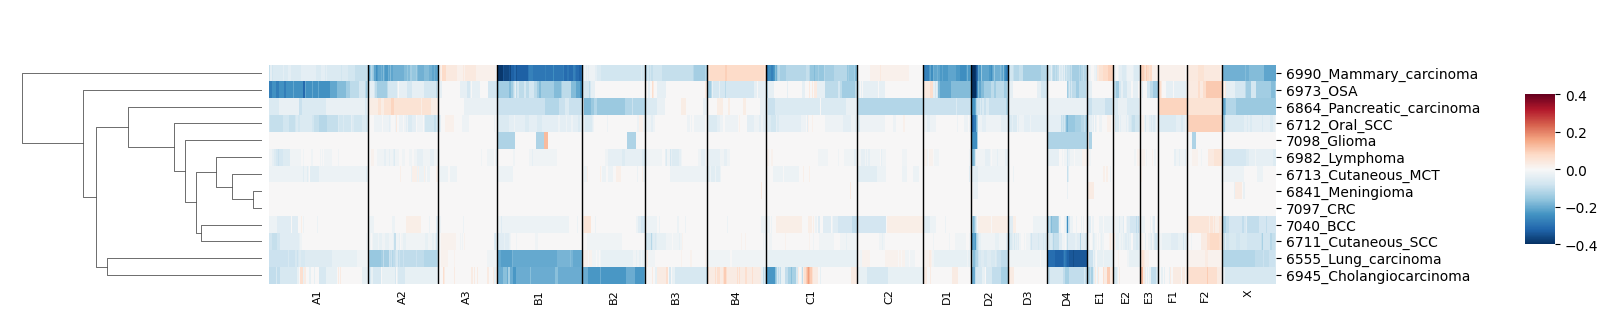

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- PLOT THE HEATMAP WITH CLUSTERING ON Y-AXIS ONLY -----
g = sns.clustermap(
    heatmap_df,
    cmap='RdBu_r',
    vmin=-0.4,
    vmax=0.4,
    figsize=(15, 5),
    col_cluster=False,
    yticklabels=True,
    # The next line controls where the colorbar appears.
    cbar_pos=(1.02, 0.5, 0.02, 0.3)  # (x, y, width, height)
)

# ----- ADD VERTICAL LINES TO SEPARATE CHROMOSOMES -----
ax = g.ax_heatmap
chrom_boundaries = []
prev_chrom = None
for i, label in enumerate(bin_labels):
    chrom = label.split(":")[0]
    if prev_chrom is None:
        prev_chrom = chrom
    elif chrom != prev_chrom:
        # The boundary is between the last bin of one chromosome and 
        # the first bin of the next, so we draw a line at i - 0.5
        chrom_boundaries.append(i - 0.5)
        prev_chrom = chrom

for boundary in chrom_boundaries:
    ax.axvline(x=boundary, color='black', linewidth=1)

# ----- GROUP INDICES BY CHROMOSOME -----
chrom_positions = {}
for i, label in enumerate(bin_labels):
    chrom = label.split(":")[0]
    chrom_positions.setdefault(chrom, []).append(i)

# Sort chromosomes if needed (optional). For example:
# chroms_sorted = sorted(chrom_positions.keys(), key=lambda c: int(c) if c.isdigit() else c)
chroms_sorted = sorted(chrom_positions.keys())

# # ----- BUILD MINOR TICKS: EVERY 10 Mbp + A TICK AT EACH CHROMOSOME BOUNDARY -----
# minor_ticks = []

# for idx, chrom in enumerate(chroms_sorted):
#     positions = chrom_positions[chrom]
#     start_pos = min(positions)  # start bin of this chromosome
#     end_pos   = max(positions)  # end bin of this chromosome
    
#     # 1) Add ticks in steps of 10 Mbp from the start to the end
#     #    (Assuming 1 bin = 1 Mbp)
#     chrom_tick_positions = np.arange(start_pos, end_pos + 1, 25)
    
#     # 2) If you also want the exact boundary at the end of this chromosome
#     #    (i.e., the start of the next chromosome) to have a tick, add (end_pos + 1)
#     #    unless this is the last chromosome.
#     if idx < len(chroms_sorted) - 1:
#         chrom_tick_positions = np.concatenate([chrom_tick_positions, [end_pos + 1]])
    
#     minor_ticks.extend(chrom_tick_positions)

# # Combine and get unique ticks (in case of overlap) and sort them
# minor_ticks = sorted(set(minor_ticks))

# # ----- SET MINOR TICKS -----
# ax.set_xticks(minor_ticks, minor=True)
# ax.tick_params(axis='x', which='minor', length=4, color='black')
# # Remove labels for minor ticks
# ax.set_xticklabels([], minor=True)

# ----- MAJOR TICKS FOR CHROMOSOME LABELS AT MIDPOINTS -----
chrom_midpoints = []
chrom_major_labels = []

for chrom in chroms_sorted:
    positions = chrom_positions[chrom]
    midpoint = np.mean(positions)
    chrom_midpoints.append(midpoint)
    chrom_major_labels.append(chrom)

ax.set_xticks(chrom_midpoints, minor=False)
ax.set_xticklabels(chrom_major_labels, rotation=90, fontsize=8)

# Remove the major tick marks so only the labels remain
ax.tick_params(axis='x', which='major', length=0)

plt.show()


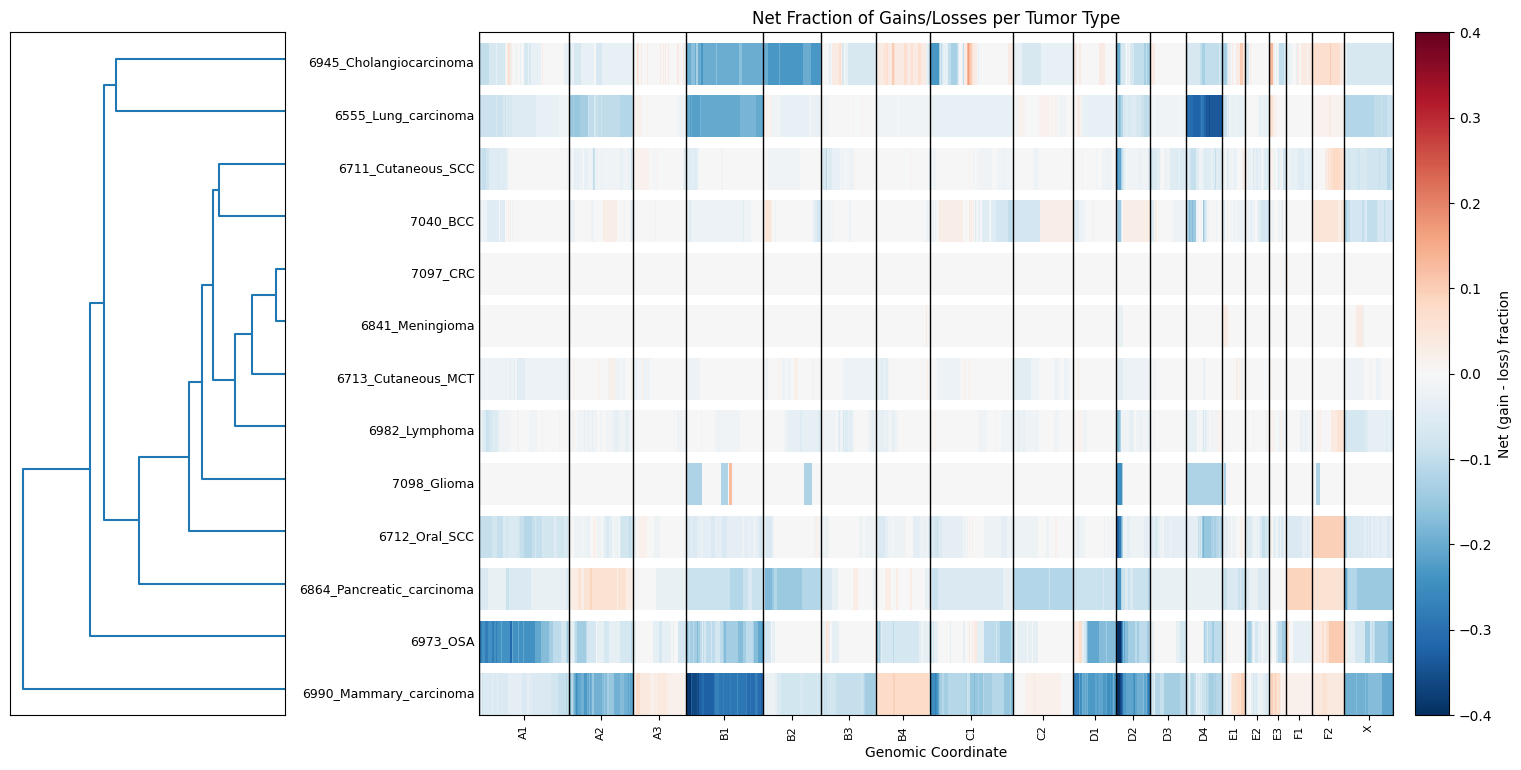

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.gridspec as gridspec

# ---------------------------------------------------------------------
# 1) Build chromosome offsets (for plotting genomic bins along x-axis).
# ---------------------------------------------------------------------
chrom_order = sorted(chrom_lengths.keys())
cum_offsets = {}
current_offset = 0
for chrom in chrom_order:
    cum_offsets[chrom] = current_offset
    current_offset += chrom_lengths[chrom]
total_genome_length = current_offset

# Create a list of global bin positions corresponding to heatmap_df.columns (the bins).
# Here, we use genome_bins (instead of bins) to avoid a naming conflict.
genome_bins = []  # This should match the variable you used when generating your heatmap.
# If you already generated the bins as a list of (chrom, start, end), use that list.
# For example:
# genome_bins = [(chrom, start, end) for chrom, start, end in <your bin generation code>]
# In our example, assume you have already generated genome_bins in your study processing code.

# If you haven't, here is the generation code (make sure you run this before the rest):
genome_bins = []
bin_labels = []
for chrom in sorted(chrom_lengths.keys()):
    length = chrom_lengths[chrom]
    for start in range(0, length, bin_size):
        end = min(start + bin_size, length)
        genome_bins.append((chrom, start, end))
        bin_labels.append(f"{chrom}:{start}-{end}")

# Now build the list of global positions:
bin_positions = []
for (chrom, start, end) in genome_bins:
    global_start = cum_offsets[chrom] + start
    global_end   = cum_offsets[chrom] + end
    bin_positions.append((global_start, global_end))

# Ensure that heatmap_df columns match the order of bin_positions.
assert len(heatmap_df.columns) == len(bin_positions), "Mismatch in bin columns vs bin_positions."

# ---------------------------------------------------------------------
# 2) Perform hierarchical clustering on the tumor rows.
# ---------------------------------------------------------------------
tumor_names = heatmap_df.index.tolist()
# Linkage on rows => each row is a tumor, each column is a bin (the net score vector).
Z = linkage(heatmap_df.values, method='average', metric='euclidean')

# Get the dendrogram ordering without plotting it yet.
dendro = dendrogram(Z, orientation='left', labels=tumor_names, no_plot=True)
row_order = dendro['leaves']

# Reorder the DataFrame by this new row order.
heatmap_df = heatmap_df.iloc[row_order, :]
tumor_names_ordered = [tumor_names[i] for i in row_order]

# ---------------------------------------------------------------------
# 3) Create a figure with two columns:
#    - Left: dendrogram
#    - Right: rectangle plot of net scores
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(16, max(4, len(tumor_names)*0.6)))
# Increase left margin so tumor labels have space (adjust as needed).
fig.subplots_adjust(left=0.2, wspace=0.05)

gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 4])
ax_dendro = fig.add_subplot(gs[0])
ax_heatmap = fig.add_subplot(gs[1])

# Plot the dendrogram on the left.
dendrogram(Z, orientation='left', labels=tumor_names, ax=ax_dendro, color_threshold=0)
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])

# ---------------------------------------------------------------------
# 4) Plot each tumor row as rectangles across genomic bins.
#    The color of each rectangle = net score in [-1, +1].
# ---------------------------------------------------------------------
norm = mcolors.Normalize(vmin=-0.4, vmax=0.4, clip=True)
cmap = cm.RdBu_r  # Red = gains, Blue = losses

n_tumors = len(heatmap_df)
for i, tumor_name in enumerate(heatmap_df.index):
    # Loop over each bin (left to right).
    for j, col in enumerate(heatmap_df.columns):
        net_score = heatmap_df.iloc[i, j]
        # Convert the bin to a global coordinate.
        global_start, global_end = bin_positions[j]
        width = global_end - global_start
        
        # Determine rectangle color based on net_score.
        rect_color = cmap(norm(net_score))
        
        # Draw a rectangle for bin j in row i.
        rect = plt.Rectangle(
            (global_start, i),  # (x, y)
            width,              # width
            0.8,                # height
            color=rect_color,
            ec=None
        )
        ax_heatmap.add_patch(rect)

    # Label the tumor name on the left side of the plot.
    ax_heatmap.text(
        -total_genome_length*0.005,  # negative => place left of 0
        i + 0.4, 
        tumor_name, 
        va='center', 
        ha='right', 
        fontsize=9
    )

ax_heatmap.set_yticks([])
ax_heatmap.set_ylim(0, n_tumors)
ax_heatmap.set_xlim(0, total_genome_length)
ax_heatmap.set_xlabel("Genomic Coordinate")
ax_heatmap.set_title("Net Fraction of Gains/Losses per Tumor Type")

# ---------------------------------------------------------------------
# 5) Add vertical lines for chromosome boundaries and x-axis labels.
# ---------------------------------------------------------------------
for chrom in chrom_order:
    offset = cum_offsets[chrom]
    ax_heatmap.axvline(offset, color='black', linewidth=1)
ax_heatmap.axvline(total_genome_length, color='black', linewidth=1)

# Label each chromosome at its midpoint.
xticks = []
xtick_labels = []
for chrom in chrom_order:
    start = cum_offsets[chrom]
    end = start + chrom_lengths[chrom]
    xticks.append((start + end) / 2)
    xtick_labels.append(chrom)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=90, fontsize=8)

# ---------------------------------------------------------------------
# 6) Add a colorbar for net_score in [-1, +1].
# ---------------------------------------------------------------------
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_heatmap, orientation='vertical', pad=0.02)
cbar.set_label("Net (gain - loss) fraction")

plt.tight_layout()
plt.show()


Processing 6555_Lung_carcinoma: 59 samples found.


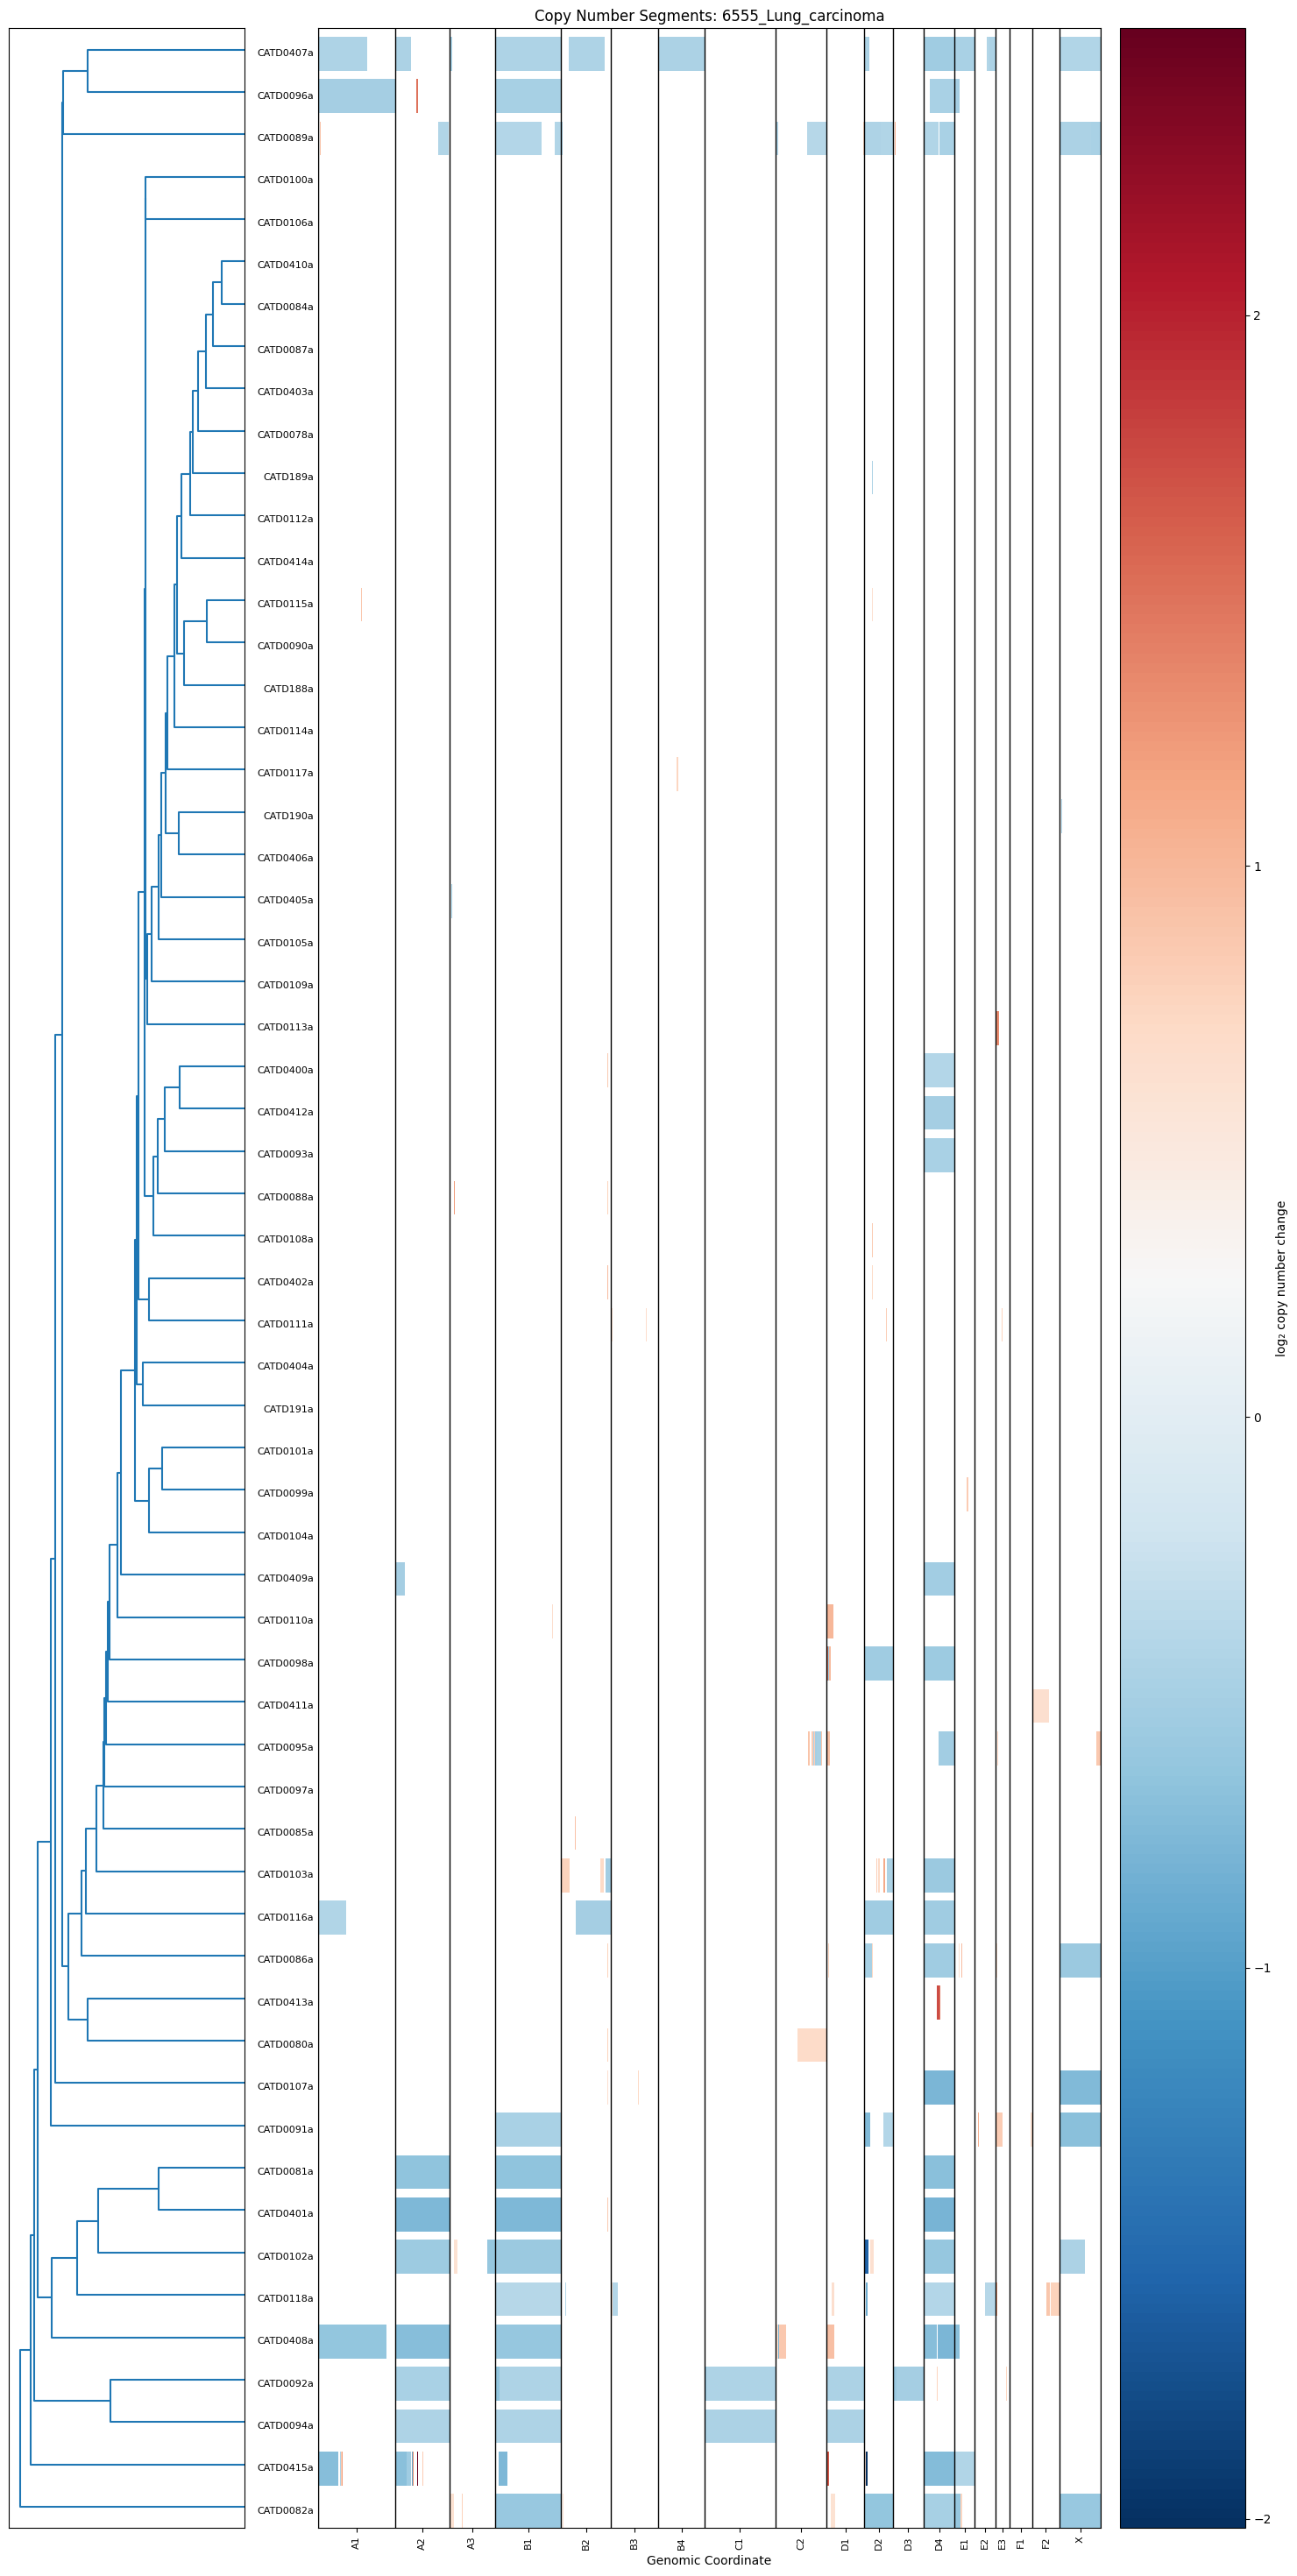

In [27]:
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from Bio import SeqIO
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.gridspec as gridspec

# ---------------------------
# Function to get chromosome lengths.
def get_chromosome_lengths(reference_fasta, ignore_prefixes=None):
    if ignore_prefixes is None:
        ignore_prefixes = []
    chrom_lengths = {}
    for record in SeqIO.parse(reference_fasta, "fasta"):
        chrom_id = record.id
        if chrom_id.lower().startswith("chr"):
            chrom_id = chrom_id[3:]
        if any(chrom_id.startswith(prefix) for prefix in ignore_prefixes):
            continue
        chrom_lengths[chrom_id] = len(record.seq)
    return chrom_lengths

# ----- PARAMETERS -----
reference_fasta = "/lustre/scratch127/bf14/analysis/fur_cnvkit/plots/data/Felis_catus.Felis_catus_9.0.dna.toplevel.fa"
ignore_prefixes = ["AANG", "KZ", "MT"]

# Define thresholds.
gain_threshold = 0.585   # Only plot gains >= this value.
loss_threshold = -0.4    # Only plot losses <= this value.

# Get chromosome lengths.
chrom_lengths = get_chromosome_lengths(reference_fasta, ignore_prefixes)

# Compute cumulative offsets for chromosomes.
chrom_order = sorted(chrom_lengths.keys())
cum_offsets = {}
current_offset = 0
for chrom in chrom_order:
    cum_offsets[chrom] = current_offset
    current_offset += chrom_lengths[chrom]
total_genome_length = current_offset

# Record chromosome boundaries for plotting.
chrom_boundaries = {chrom: cum_offsets[chrom] + chrom_lengths[chrom] for chrom in chrom_order}

# Define glob patterns for tumor types.
tumor_dirs = {
    '6555_Lung_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6555_Lung_carcinoma/*.call.median_centred.cns',
    '6712_Oral_SCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6712_Oral_SCC/*.call.median_centred.cns',
    '6841_Meningioma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6841_Meningioma/*.call.median_centred.cns',
    '6945_Cholangiocarcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6945_Cholangiocarcinoma/*.call.median_centred.cns',
    '6982_Lymphoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6982_Lymphoma/*.call.median_centred.cns',
    '7040_BCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7040_BCC/*.call.median_centred.cns',
    '7098_Glioma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7098_Glioma/*.call.median_centred.cns',
    '6711_Cutaneous_SCC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6711_Cutaneous_SCC/*.call.median_centred.cns',
    '6713_Cutaneous_MCT': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6713_Cutaneous_MCT/*.call.median_centred.cns',
    '6864_Pancreatic_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6864_Pancreatic_carcinoma/*.call.median_centred.cns',
    '6973_OSA': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6973_OSA/*.call.median_centred.cns',
    '6990_Mammary_carcinoma': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/6990_Mammary_carcinoma/*.call.median_centred.cns',
    '7097_CRC': '/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/7097_CRC/*.call.median_centred.cns'
}

# For this example, we'll process one tumor type.
tumor = '6555_Lung_carcinoma'
pattern = tumor_dirs[tumor]
files = glob.glob(pattern)
print(f"Processing {tumor}: {len(files)} samples found.")

# ---------------------------
# Define binning scheme: Use 1 Mbp bins across the genome.
bin_size = 1000000  # 1 million base pairs
bins = np.arange(0, total_genome_length + bin_size, bin_size)
n_bins = len(bins) - 1

# Function to create a binned copy number profile for one sample.
def create_profile_vector(df):
    profile = np.zeros(n_bins)
    for _, row in df.iterrows():
        chrom = row['chromosome']
        if chrom not in cum_offsets:
            continue
        seg_start = row['start']
        seg_end = row['end']
        global_start = cum_offsets[chrom] + seg_start
        global_end = cum_offsets[chrom] + seg_end
        # Find the bin indices that the segment spans.
        start_bin = np.searchsorted(bins, global_start, side='right') - 1
        end_bin = np.searchsorted(bins, global_end, side='right') - 1
        profile[start_bin:end_bin+1] = row['log2']
    return profile

# ---------------------------
# Build a profile matrix and collect sample names.
profiles = []
sample_names = []
for file in files:
    df = pd.read_csv(file, sep='\t')
    # Ensure consistency: remove any 'chr' prefix.
    df['chromosome'] = df['chromosome'].astype(str).str.replace('chr', '', regex=False)
    profile = create_profile_vector(df)
    profiles.append(profile)
    sample_names.append(file.split('/')[-1].split('.')[0])
profiles = np.array(profiles)

# ---------------------------
# Perform hierarchical clustering.
Z = linkage(profiles, method='average', metric='euclidean')
# Create dendrogram to obtain sample order (but do not plot it here yet).
dendro = dendrogram(Z, orientation='left', labels=sample_names, no_plot=True)
order = dendro['leaves']

# For the segmentation plot, determine the tumor-specific range using only segments outside the neutral zone.
all_log2_values = []
for file in files:
    df = pd.read_csv(file, sep='\t')
    for val in df['log2'].values:
        if val <= loss_threshold or val >= gain_threshold:
            all_log2_values.append(val)
tumor_min = min(all_log2_values) if all_log2_values else loss_threshold
tumor_max = max(all_log2_values) if all_log2_values else gain_threshold
norm = colors.Normalize(vmin=tumor_min, vmax=tumor_max)
cmap = cm.RdBu_r

# ---------------------------
# Set up a figure with more space on the left.
fig = plt.figure(figsize=(15, max(4, len(files)*0.5)))
# Increase left margin to avoid overlap with sample labels.
fig.subplots_adjust(left=0.2, wspace=0.05)

# Create a GridSpec with two columns: dendrogram (left), CN plot (right).
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 4])
ax_dendro = fig.add_subplot(gs[0])
ax_cn = fig.add_subplot(gs[1])

# Plot the dendrogram on the left.
dendrogram(Z, orientation='left', labels=sample_names, ax=ax_dendro, color_threshold=0)
ax_dendro.set_xticks([])
ax_dendro.set_yticks([])

# ---------------------------
# Plot the copy number segments, reordering samples by the clustering order.
for i, idx in enumerate(order):
    file = files[idx]
    df = pd.read_csv(file, sep='\t')
    df['chromosome'] = df['chromosome'].astype(str).str.replace('chr', '', regex=False)
    for _, row in df.iterrows():
        chrom = row['chromosome']
        if chrom not in cum_offsets:
            continue
        seg_start = row['start']
        seg_end = row['end']
        global_start = cum_offsets[chrom] + seg_start
        global_end = cum_offsets[chrom] + seg_end
        seg_width = global_end - global_start
        log2_val = row['log2']
        # Only plot segments with changes outside the neutral zone.
        if loss_threshold < log2_val < gain_threshold:
            continue
        rect_color = cmap(norm(log2_val))
        rect = patches.Rectangle((global_start, i), seg_width, 0.8, color=rect_color, ec=None)
        ax_cn.add_patch(rect)

    # Label the sample name on the left side of the copy number plot.
    # You can adjust the offset multiplier (currently 0.005) if you need more or less space.
    ax_cn.text(-total_genome_length*0.005, i+0.4, sample_names[idx], va='center', ha='right', fontsize=8)

ax_cn.set_yticks([])
ax_cn.set_ylim(0, len(files))
ax_cn.set_xlim(0, total_genome_length)
ax_cn.set_xlabel("Genomic Coordinate")
ax_cn.set_title(f"Copy Number Segments: {tumor}")

# Add vertical lines to mark chromosome boundaries.
for chrom in chrom_order:
    offset = cum_offsets[chrom]
    ax_cn.axvline(offset, color='black', linewidth=1)
ax_cn.axvline(total_genome_length, color='black', linewidth=1)

# Set x-ticks at the midpoints of each chromosome.
xticks = []
xtick_labels = []
for chrom in chrom_order:
    start = cum_offsets[chrom]
    end = start + chrom_lengths[chrom]
    xticks.append((start + end) / 2)
    xtick_labels.append(chrom)
ax_cn.set_xticks(xticks)
ax_cn.set_xticklabels(xtick_labels, rotation=90, fontsize=8)

# Add a colorbar for the log2 values.
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_cn, orientation='vertical', pad=0.02)
cbar.set_label('log₂ copy number change')

plt.tight_layout()
plt.show()
